In [5]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mp
from matplotlib import cm
from collections import OrderedDict
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold

from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import cross_validate,cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
import time
warnings.filterwarnings('ignore')

# Functions/Classes

In [6]:
def check(x,n):
    val = 0
    if x > n:
        val = 1
    return val

class stats_met:
    """
    定义一个类，用来分类器的性能度量
    """
    def __init__(self, labels, scores):
        """
        :param labels:数组类型，真实的标签
        :param scores:数组类型，分类器的得分
        """
        self.labels = labels
        self.scores = scores
        self.TP, self.FP, self.FN, self.TN = self.get_confusion_matrix()
    
    def accuracy(self):
        """
        :return: 准确率
        """
        accuracy = (self.TP + self.TN) / (self.TP + self.FN + self.FP + self.TN)
        
        return accuracy
 
    def precision(self):
        """
        :return: 精准度
        """
        try:
            precision = self.TP / (self.TP + self.FP)
        except ZeroDivisionError:
            precision = np.nan
        
        return precision
 
    def recall(self):
        """
        :return: 召回率
        """
        try:
            recall = self.TP / (self.TP + self.FN)
        except ZeroDivisionError:
            recall = np.nan
        
        return recall
    
    def f_beta(self,beta):
        precision = self.precision()
        recall = self.recall()
        
        f_score = (1+beta**2)*((precision*recall/((beta**2)*precision+recall)))
        return f_score
 
    def get_confusion_matrix(self):
        """
        计算混淆矩阵
        :return:
        """
        tp, fp, fn, tn = 0., 0., 0., 0.
        for i in range(len(self.labels)):
            if self.labels[i] == 1 and self.scores[i] == 1:
                tp += 1
            elif self.labels[i] == 0 and self.scores[i] == 1:
                fp += 1
            elif self.labels[i] == 1 and self.scores[i] == 0:
                fn += 1
            else:
                tn += 1
        return [tp, fp, fn, tn]
    
    def get_eval_metrics(self):
        print("Precision = {:0.3f},Recall = {:0.3f}, F_score = {:0.3f}".format(self.precision(),self.recall(),self.f_beta(beta = 0.3)))
    
        
    
## Adjust graph spines
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 20))  # outward by 10 points
            #spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine
            
## function of getting the optimized paramters and score
def hypertuning_rscv(est,p_distr,nbr_iter,X,y):
    rdmsearch = RandomizedSearchCV(est, param_distributions=p_distr,n_jobs=-1,scoring = 'roc_auc', n_iter=nbr_iter,cv=5)
    
    rdmsearch.fit(X,y)
    ht_params = rdmsearch.best_params_
    ht_score = rdmsearch.best_score_
    return(ht_params,ht_score)

def sort_feature_importance(importance,names):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    fea_data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(fea_data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'],ascending = True,ignore_index=True,inplace = True)
    return fi_df


def visualization(recall,precision,f_score,threshold,threshold_max):
    fig, ax = plt.subplots(1,1,figsize=(10,9))

    colors = [plt.cm.tab10(i/float(5)) for i in range(3)]
    
    min_y = round(min(f_score),2)
    max_y = round(max(f_score),2)
    
    min_y_per = round(min(f_score*100))
    max_y_per = round(max(f_score*100))
    
    ax.plot(threshold,f_score,alpha = 0.3,color = colors[1],linewidth = "1")
    ax.scatter(threshold,f_score,alpha = 0.9,color = colors[1],s = 0.38)
    
    ax.axvline(thre_max, color="black", linestyle="dashed")

    ax.tick_params(axis= "both",direction = 'out',which='major', length=6.8,width=1, color='k',labelsize = 18)
    ax.set_xticks([0.05*i for i in range(9,13)])
    ax.set_yticks([0.01*i for i in range(min_y_per,max_y_per+1)])
    ax.set_ylabel("F score",size = 25,labelpad=12)
    ax.set_xlabel("Threshold",size = 25,labelpad=12)
    ax.set_title("F_0.3 vs threshold",size = 30)

    ax.spines['left'].set_bounds(0.52,0.56)
    ax.spines['bottom'].set_bounds(0.45,0.6)
    ax.legend(fontsize = 25)

    adjust_spines(ax, ['left', 'bottom'])
    
### K fold target encoding for training test
class KFoldTargetEncoderTrain(BaseEstimator,TransformerMixin):

    def __init__(self, colnames,targetName,n_fold=5,verbosity=True,discardOriginal_col=False):

        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col

    def fit(self, X, y=None):
        return self


    def transform(self,X):

        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)

        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold, shuffle = True, random_state=2019)



        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan

        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]

            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].map(X_tr.groupby(self.colnames)[self.targetName].mean())

        X[col_mean_name].fillna(mean_of_target, inplace = True)

        if self.verbosity:

            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name,
                                                                                      self.targetName,
                                                                                      np.corrcoef(X[self.targetName].values, encoded_feature)[0][1]))
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
            

        return(X)
    
### K Fold target encoding for test set
class KFoldTargetEncoderTest(BaseEstimator, TransformerMixin):
    
    def __init__(self,train,colNames,encodedName):
        
        self.train = train
        self.colNames = colNames
        self.encodedName = encodedName
        
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        mean =  self.train[[self.colNames,
                self.encodedName]].groupby(
                                self.colNames).mean().reset_index() 
        
        dd = {}
        for index, row in mean.iterrows():
            dd[row[self.colNames]] = row[self.encodedName]
        X[self.encodedName] = X[self.colNames]
        X = X.replace({self.encodedName: dd})
    
        return(X)
    
def model_train(cla,param_dist,nbr_iter,X_train,y_train,target_train,X_cv,y_cv,target_cv,X_val,y_val,target_val,X_test,y_test,target_test,plot = False,plot_fea = False):
    ## -------------------model training-------------------
    start_time = time.time()
    
    random_params, random_score = hypertuning_rscv(cla(),param_dist,nbr_iter, X_cv, y_cv)
    
    classifier_1 = cla(**random_params)
    classifier_1.fit(X_cv,y_cv)
    
    
    print("The selected set of hyperparameters[xgb] is {}.".format(random_params))
    ##-------------------F score extraction-------------------
    
    #pred_val = np.array(classifier_1.predict(X_val))
    prob_val = np.array(classifier_1.predict_proba(X_val)[:,1])

    interval = 0.2/10000
    threshold = [0.4 + i*interval for i in range(10001)]

    frame = pd.DataFrame()
    scores_cla = [1]*X_val.shape[0]
    
    for i in threshold:    
        scores_cla = [1 if j > i else 0 for j in prob_val]
        
        scores_val = list(scores_cla)
        label_val = list(target_val)
        
        cl = stats_met(label_val,scores_val)
        
        precision = cl.precision()
        
        recall = cl.recall()
        
        f_beta = cl.f_beta(beta = 0.3)

        frame_row = {"threshold":i,"Precision":precision,"Recall":recall,"F_beta":f_beta}
        frame = frame.append(frame_row,ignore_index=True)
    
    
    threshold_max = frame.loc[frame.F_beta == max(frame.F_beta),"threshold"].iloc[0]
    
    scores_val = [1 if j > threshold_max else 0 for j in prob_val]

    labels_val = list(target_val)
    
    val_metrics = stats_met(labels_val,scores_val)
    
    print("---The metric scores of the validation set is---")
    val_metrics.get_eval_metrics()
    
    if plot:
        threshold = frame["threshold"]
        f_score = frame["F_beta"]
        precision = frame["Precision"]
        recall = frame["Recall"]

        visualization(recall,precision,f_score,threshold,threshold_max)
    
    if plot_fea:
        plt.rcParams['figure.figsize'] = [18,18]
        plot_importance(classifier_1)
        plt.show()  
    
    ## -------------------Training the whole dataset-------------------
    classifier_2 = cla(**random_params)
    classifier_2.fit(X_train,y_train)


    pred_test = classifier_2.predict_proba(X_test)[:,1]

    classifier_2.fit(X_train,y_train)

    sma_barr_scores_1 = list(pred_test) 
    sma_barr_scores_2 = [1 if k > threshold_max else 0 for k in sma_barr_scores_1]

    labels_test = list(target_test) ## delete expectancy
    scores_test = sma_barr_scores_2

    test_metrics = stats_met(labels_test,scores_test)

    print("---The metric scores of the test set is---")
    test_metrics.get_eval_metrics()

    print("--- %s seconds ---" % (time.time() - start_time))
    return([threshold_max,random_params])

In [3]:
july_poked = pd.read_csv('july_poked.csv',encoding = "GBK")
aug_small_bucket = pd.read_csv('aug_small_bucket.csv',encoding = "GBK")

In [4]:
july_poked.fillna(0,inplace = True)
aug_small_bucket.fillna(0,inplace = True)

In [5]:
july_poked["key_2"] = july_poked["city_code"].astype("str") + "_" + july_poked["l2_code"].astype("str") 
aug_small_bucket["key_2"] = aug_small_bucket["city_code"].astype("str") + "_" + aug_small_bucket["l2_code"].astype("str") 

july_poked["key_3"] = july_poked["city_code"].astype("str") + "_" + july_poked["l2_code"].astype("str") + "_" + july_poked["com_id"].astype("str")
aug_small_bucket["key_3"] = aug_small_bucket["city_code"].astype("str") + "_" + aug_small_bucket["l2_code"].astype("str") + "_" + aug_small_bucket["com_id"].astype("str")

In [6]:
july_poked.drop(["city_code",'l2_code','com_id'],axis = 1,inplace = True)
aug_small_bucket.drop(["city_code",'l2_code','com_id'],axis = 1,inplace = True)

In [7]:
corr_dat = pd.DataFrame({"Features":july_poked.iloc[:,list(range(5,92))].columns,"Correlation":pd.Series(july_poked.iloc[:,list(range(5,92))].columns).apply(lambda col:np.corrcoef(july_poked[col],july_poked["del_exp_cnt"])[0,1])})
corr_dat.sort_values(by=['Correlation'],ascending = True,ignore_index=True,inplace = True)
corr_select = corr_dat.loc[corr_dat.Correlation>=0.6,:].reset_index(drop = True)

tot_dat = july_poked.loc[:,list(corr_select.Features) + list(july_poked[["is_paid","is_del","key_2","key_3"]].columns)] ## chosen variables plus target and y
tot_dat_test = aug_small_bucket.loc[:,list(corr_select.Features) + list(aug_small_bucket[["is_paid","is_del","is_poked","key_2","key_3"]].columns)]

tot_dat_test_poked = tot_dat_test.loc[tot_dat_test.is_poked == "poked",:]

In [8]:
july_poked.columns

Index(['is_poked', 'is_paid', 'sales', 'is_del', 'del_exp_cnt', 'olj_1',
       'olj_14', 'olj_30', 'olj_90', 'olj_180', 'olj_365', 'olj_past_same',
       'actj_1', 'actj_14', 'actj_30', 'actj_90', 'actj_180', 'actj_365',
       'actj_past_same', 'newj_1', 'newj_14', 'newj_30', 'newj_90', 'newj_180',
       'newj_365', 'newj_past_same', 'exposure_pv_14', 'exposure_pv_30',
       'exposure_pv_90', 'exposure_pv_180', 'exposure_pv_365',
       'exposure_pv_past_same', 'view_a_14', 'view_a_30', 'view_a_90',
       'view_a_180', 'view_a_365', 'view_a_past_same', 'add_a_14', 'add_a_30',
       'add_a_90', 'add_a_180', 'add_a_365', 'add_a_past_same',
       'chatback_a_14', 'chatback_a_30', 'chatback_a_90', 'chatback_a_180',
       'chatback_a_365', 'chatback_a_past_same', 'accepts_a_14',
       'accepts_a_30', 'accepts_a_90', 'accepts_a_180', 'accepts_a_365',
       'accepts_a_past_same', 'view_p_14', 'view_p_30', 'view_p_90',
       'view_p_180', 'view_p_365', 'view_p_past_same', 'add_p_14

# Data preprocesing

In [9]:
tot_dat[["is_paid","is_del"]] = tot_dat[["is_paid","is_del"]].apply(lambda x: x.astype('str'))
tot_dat_test_poked[["is_paid","is_del"]] = tot_dat_test_poked[["is_paid","is_del"]].apply(lambda x: x.astype('str'))

In [10]:
## training
tot_dat.loc[tot_dat["is_paid"] == "paid","is_paid"] = 1
tot_dat.loc[tot_dat["is_paid"] == "unpaid","is_paid"] = 0

tot_dat.loc[tot_dat["is_del"] == "deleted","is_del"] = 1
tot_dat.loc[tot_dat["is_del"] == "undeleted","is_del"] = 0

tot_dat[["is_paid","is_del"]] = tot_dat[["is_paid","is_del"]].apply(lambda x: x.astype('int'))

## testing
tot_dat_test_poked.loc[tot_dat_test_poked["is_paid"] == "paid","is_paid"] = 1
tot_dat_test_poked.loc[tot_dat_test_poked["is_paid"] == "unpaid","is_paid"] = 0

tot_dat_test_poked.loc[tot_dat_test_poked["is_del"] == "deleted","is_del"] = 1
tot_dat_test_poked.loc[tot_dat_test_poked["is_del"] == "undeleted","is_del"] = 0

tot_dat_test_poked[["is_paid","is_del"]] = tot_dat_test_poked[["is_paid","is_del"]].apply(lambda x: x.astype('int'))

In [11]:
## sub_training and validation set preparation
key2_train = tot_dat["key_2"]
key3_train = tot_dat["key_3"]
X_train = tot_dat.drop(["is_paid","key_2","key_3"],axis = 1)
target_train = tot_dat["is_paid"]
y_train = tot_dat["is_del"]

X_cv, X_val, target_cv, target_val = train_test_split(X_train,target_train, test_size=0.3, random_state=18) 

y_cv = X_cv["is_del"]
y_val = X_val["is_del"]

X_train.drop("is_del",axis = 1,inplace = True)
X_cv.drop("is_del",axis = 1,inplace = True)
X_val.drop("is_del",axis = 1,inplace = True)

## test data preparation
key_test_poked = tot_dat_test_poked[["key_2","key_3"]]
X_test_poked = tot_dat_test_poked.drop(["is_paid","is_poked","key_2","key_3"],axis =1)
target_test_poked = tot_dat_test_poked["is_paid"]
y_test_poked = tot_dat_test_poked["is_del"]

X_test_poked.drop("is_del",axis = 1,inplace = True)

## XGBOOST

In [324]:
cla = XGBClassifier
param_xgb ={
        "objective":['reg:logistic'],
        "booster":["gbtree"],
        'n_estimators': [300],
        'min_child_weight': list(range(3,9)), #****
        'max_depth': list(range(5,11)),       #****
        'gamma': [0,1,5,7,10],              #***
        'subsample': [round(0.1*i,2) for i in range(6,11)],    #**
        'colsample_bytree': [round(0.1*i,2) for i in range(6,11)],  #**
        'eta': [0.1,0.2], #*
        'reg_alpha':[0,0.01, 0.05],#*
        'random_state':[68]
}

nbr_iter = 18

## training set
X_train = X_train
y_train = y_train
target_train = target_train

## sub training set
X_cv = X_cv
y_cv = y_cv
target_cv = target_cv

## validation set
X_val = X_val
y_val = y_val
target_val = target_val

## test set
X_test = X_test_poked
y_test = y_test_poked
target_test = target_test_poked

In [325]:
model_train(cla,param_xgb,nbr_iter,X_train,y_train,target_train,X_cv,y_cv,target_cv,X_val,y_val,target_val,X_test,y_test,target_test,plot = False,plot_fea = False)

The selected set of hyperparameters[xgb] is {'subsample': 0.7, 'reg_alpha': 0, 'random_state': 68, 'objective': 'reg:logistic', 'n_estimators': 300, 'min_child_weight': 8, 'max_depth': 8, 'gamma': 10, 'eta': 0.1, 'colsample_bytree': 0.9, 'booster': 'gbtree'}.
---The metric scores of the validation set is---
Precision = 0.555,Recall = 0.465, F_score = 0.546
---The metric scores of the test set is---
Precision = 0.482,Recall = 0.519, F_score = 0.484
--- 959.6645882129669 seconds ---


## RandomForest

In [ ]:
cla = RandomForestClassifier

param_rf = {
    'criterion':['gini','entropy'],
    'min_samples_split':[2,3,5,6,8,10,12],
    'bootstrap': [True],
    'max_depth': [i for i in range(1,6)],
    'max_features': [i for i in range(6,12)],
    'min_samples_leaf': [3,4,5,6,7],
    'min_samples_split': [2,3,5,6],
    'n_estimators': [300,500,800]
}


cla()

In [ ]:
cla = RandomForestClassifier

param_rf = {
    'criterion':['gini','entropy'],
    'min_samples_split':[2,3,5,6,8,10,12],
    'bootstrap': [True],
    'max_depth': [i for i in range(1,6)],
    'max_features': [i for i in range(6,12)],
    'min_samples_leaf': [3,4,5,6,7],
    'min_samples_split': [2,3,5,6],
    'n_estimators': [300,500,800]
}

nbr_iter = 18

## training set
X_train = X_train
y_train = y_train
target_train = target_train

## sub training set
X_cv = X_cv
y_cv = y_cv
target_cv = target_cv

## validation set
X_val = X_val
y_val = y_val
target_val = target_val

## test set
X_test = X_test
y_test = y_test
target_test = target_test

In [ ]:
model_train(cla,param_rf,nbr_iter,X_train,y_train,target_train,X_cv,y_cv,target_cv,X_val,y_val,target_val,X_test,y_test,target_test,plot = False,plot_fea = False)

## Prediction with small job bucket

## Data Preprocessing

In [12]:
july_small_poked = july_poked.loc[july_poked["key_2"].isin(list(aug_small_bucket["key_2"].unique())),:].reset_index(drop = True)

In [13]:
july_small_poked

,is_poked,is_paid,sales,is_del,del_exp_cnt,olj_1,olj_14,olj_30,olj_90,olj_180,...,duplicate_af_uv_365,duplicate_af_uv_past_same,duplicate_af_pv_14,duplicate_af_pv_30,duplicate_af_pv_90,duplicate_af_pv_180,duplicate_af_pv_365,duplicate_af_pv_past_same,key_2,key_3
0,poked,unpaid,0.0,undeleted,0,0,0,0,0,1,...,46.0,0.0,0.0,0.0,0.0,46.0,46.0,0.0,101010100_180300,101010100_180300_599367
1,poked,unpaid,0.0,undeleted,0,0,0,1,1,1,...,84.0,61.0,0.0,0.0,4.0,16.0,88.0,61.0,101010100_180300,101010100_180300_1970217
2,poked,paid,60.0,undeleted,0,0,0,0,0,1,...,72.0,0.0,0.0,0.0,0.0,72.0,72.0,0.0,101010100_180300,101010100_180300_2026341
3,poked,unpaid,0.0,undeleted,0,0,0,0,0,0,...,59.0,73.0,0.0,0.0,0.0,1.0,61.0,74.0,101010100_180300,101010100_180300_2636043
4,poked,unpaid,0.0,undeleted,0,0,0,0,0,1,...,44.0,4.0,0.0,0.0,1.0,3.0,44.0,4.0,101010100_180300,101010100_180300_4517955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5402,poked,unpaid,0.0,undeleted,0,0,0,0,0,0,...,17.0,1.0,0.0,0.0,0.0,0.0,17.0,1.0,101310200_160100,101310200_160100_13610136
5403,poked,unpaid,0.0,undeleted,0,0,0,0,0,0,...,3.0,3.0,0.0,0.0,0.0,0.0,4.0,3.0,101310200_160100,101310200_160100_18831636
5404,poked,unpaid,0.0,undeleted,0,0,0,1,1,1,...,302.0,0.0,0.0,0.0,77.0,232.0,302.0,0.0,101310200_160100,101310200_160100_29662668
5405,poked,unpaid,0.0,deleted,2,0,0,1,1,1,...,11.0,0.0,0.0,1.0,3.0,10.0,11.0,0.0,101310200_160100,101310200_160100_30918798


In [16]:
# corr_dat = pd.DataFrame({"Features":july_small_poked.iloc[:,list(range(8,95))].columns,"Correlation":pd.Series(july_small_poked.iloc[:,list(range(8,95))].columns).apply(lambda col:np.corrcoef(july_poked[col],july_poked["del_exp_cnt"])[0,1])})
# corr_select = corr_dat.loc[corr_dat.Correlation>=0.5,:].reset_index(drop = True)
# corr_select = corr_dat.loc[corr_dat]
# features = ['duplicate_af_pv_365','chatback_a_180','duplicate_af_pv_365','duplicate_af_uv_14','add_a_14','duplicate_af_uv_180','duplicate_af_pv_14','duplicate_af_pv_14','duplicate_af_pv_30','add_a_365','duplicate_af_uv_90','chatback_a_90','view_p_14','actj_1','chatback_a_14','newj_14','accepts_a_180','olj_1','view_p_30','duplicate_af_uv_30','add_a_180','olj_90','duplicate_af_pv_90','duplicate_af_pv_180','add_a_30','actj_180','view_a_90','chatback_a_30','add_a_90','accepts_a_365','actj_14','accepts_a_30']

# tot_dat = july_small_poked.loc[:,list(np.unique(features)) + list(july_poked[["is_paid","is_del"]].columns)] ## chosen variables plus target and y
# tot_dat_test = aug_small_bucket.loc[:,list(np.unique(features)) + list(aug_small_bucket[["is_paid","is_del","is_poked"]].columns)]

# tot_dat = july_small_poked.iloc[:,[4,6]+list(range(8,95))]
# tot_dat_test = aug_small_bucket


# tot_dat_test_poked = tot_dat_test.loc[tot_dat_test.is_poked == "poked",:].reset_index(drop = True)
# tot_dat_test_poked = tot_dat_test_poked.iloc[:,[4,6]+list(range(8,95))]

In [15]:
tot_dat.columns

Index(['olj_30', 'newj_14', 'olj_14', 'duplicate_af_uv_180', 'newj_30',
       'actj_30', 'accepts_a_14', 'add_a_180', 'accepts_a_30', 'actj_1',
       'duplicate_af_uv_90', 'actj_14', 'duplicate_af_pv_180', 'add_a_90',
       'duplicate_af_uv_30', 'duplicate_af_pv_90', 'duplicate_af_uv_14',
       'add_a_30', 'duplicate_af_pv_30', 'add_a_14', 'duplicate_af_pv_14',
       'is_paid', 'is_del', 'key_2', 'key_3'],
      dtype='object')

In [10]:
tot_dat[["is_paid","is_del"]] = tot_dat[["is_paid","is_del"]].apply(lambda x: x.astype('str'))
tot_dat_test_poked[["is_paid","is_del"]] = tot_dat_test_poked[["is_paid","is_del"]].apply(lambda x: x.astype('str'))

In [34]:
## training
tot_dat.loc[tot_dat["is_paid"] == "paid","is_paid"] = 1
tot_dat.loc[tot_dat["is_paid"] == "unpaid","is_paid"] = 0

tot_dat.loc[tot_dat["is_del"] == "deleted","is_del"] = 1
tot_dat.loc[tot_dat["is_del"] == "undeleted","is_del"] = 0

tot_dat[["is_paid","is_del"]] = tot_dat[["is_paid","is_del"]].apply(lambda x: x.astype('int'))

## testing
tot_dat_test_poked.loc[tot_dat_test_poked["is_paid"] == "paid","is_paid"] = 1
tot_dat_test_poked.loc[tot_dat_test_poked["is_paid"] == "unpaid","is_paid"] = 0

tot_dat_test_poked.loc[tot_dat_test_poked["is_del"] == "deleted","is_del"] = 1
tot_dat_test_poked.loc[tot_dat_test_poked["is_del"] == "undeleted","is_del"] = 0

tot_dat_test_poked[["is_paid","is_del"]] = tot_dat_test_poked[["is_paid","is_del"]].apply(lambda x: x.astype('int'))

In [36]:
## sub_training and validation set preparation
X_train = tot_dat.drop("is_paid",axis = 1)
target_train = tot_dat["is_paid"]
y_train = tot_dat["is_del"]

X_cv, X_val, target_cv, target_val = train_test_split(X_train,target_train, test_size=0.3, random_state=18) 

y_cv = X_cv["is_del"]
y_val = X_val["is_del"]

X_train.drop("is_del",axis = 1,inplace = True)
X_cv.drop("is_del",axis = 1,inplace = True)
X_val.drop("is_del",axis = 1,inplace = True)

## test data preparation
X_test = tot_dat_test_poked.drop(["is_paid"],axis =1)
target_test = tot_dat_test_poked["is_paid"]
y_test = tot_dat_test_poked["is_del"]

X_test.drop("is_del",axis = 1,inplace = True)

## pca transformation

In [ ]:
# ## create the object
# scaler = StandardScaler()

# ## calculate the mean and standard deviation
# scaler.fit(X_train)

# ## Transform the values
# X_train_scaled = scaler.transform(X_train)

# pca = PCA(n_components = 6,random_state = 8)
# pca.fit(X_train_scaled)
# X_train_pca = pca.transform(X_train_scaled)

# # training variance explained
# var_exp_training = pca.explained_variance_ratio_*100
# var_exp_training = var_exp.round(decimals = 2)


# ## pca visualization for training test
# fig, ax = plt.subplots(1,1,figsize=(8,7))
# NUM_COLORS = 6
# cm = plt.get_cmap('gist_rainbow')
# colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

# PC = pd.Series(["PC1","PC2","PC3","PC4","PC5","PC6"])
# Variance = pd.Series(var_exp_training)

# ax.bar(PC,Variance,color = colors)
# ax.plot(PC,Variance,alpha = 0.3,color = 'darkgreen',linewidth = "3")
# ax.scatter(PC,Variance,alpha = 0.9,color = 'darkgreen')
# for p in ax.patches:
#     percentage = '{}%'.format(p.get_height())
#     x = p.get_x() + p.get_width()/8
#     y = p.get_y() + p.get_height()+0.5
#     ax.annotate(percentage, (x, y),size = 20)

# ax.tick_params(axis= "both",direction = 'out',which='major', length=8,width=1.38, color='k',labelsize = 18)

# ax.set_xticks(PC)
# ax.set_yticks(list(range(0,100,20)))

# ax.spines['left'].set_bounds(0,80)
# ax.spines['bottom'].set_bounds(0,5)

# ax.set_ylabel("Variance Explained (%)",size = 25,labelpad=12)
# ax.set_xlabel("Principal Components",size = 25,labelpad=12)

# adjust_spines(ax, ['left', 'bottom'])

# X_train_pca = pd.DataFrame(X_train_pca)
# X_train_pca.columns = PC

# X_cv_pca, X_val_pca, target_cv_pca, target_val_pca = train_test_split(X_train_pca,target_train, test_size=0.3, random_state=18)

# ## create the object
# scaler = StandardScaler()

# ## calculate the mean and standard deviation
# scaler.fit(X_test)

# ## Transform the values
# X_test_scaled = scaler.transform(X_test)

# pca = PCA(n_components = 6,random_state = 8)
# pca.fit(X_test_scaled)
# X_test_pca = pca.transform(X_test_scaled)

# # variance explained
# var_exp_test = pca.explained_variance_ratio_*100
# var_exp_test = var_exp.round(decimals = 2)

# fig, ax = plt.subplots(1,1,figsize=(8,7))
# NUM_COLORS = 6
# cm = plt.get_cmap('gist_rainbow')
# colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

# PC = pd.Series(["PC1","PC2","PC3","PC4","PC5","PC6"])
# Variance = pd.Series(var_exp_test)

# ax.bar(PC,Variance,color = colors)
# ax.plot(PC,Variance,alpha = 0.3,color = 'darkgreen',linewidth = "3")
# ax.scatter(PC,Variance,alpha = 0.9,color = 'darkgreen')
# for p in ax.patches:
#     percentage = '{}%'.format(p.get_height())
#     x = p.get_x() + p.get_width()/8
#     y = p.get_y() + p.get_height()+0.5
#     ax.annotate(percentage, (x, y),size = 20)

# ax.tick_params(axis= "both",direction = 'out',which='major', length=8,width=1.38, color='k',labelsize = 18)

# ax.set_xticks(PC)
# ax.set_yticks(list(range(0,100,20)))

# ax.spines['left'].set_bounds(0,80)
# ax.spines['bottom'].set_bounds(0,5)

# ax.set_ylabel("Variance Explained (%)",size = 25,labelpad=12)
# ax.set_xlabel("Principal Components",size = 25,labelpad=12)

# adjust_spines(ax, ['left', 'bottom'])

## XGBOOST

In [79]:
cla = XGBClassifier
param_grid ={
        "objective":['reg:logistic'],
        "booster":["gbtree"],
        'n_estimators': [180],
        'min_child_weight': list(range(3,9)), #****
        'max_depth': list(range(2,11)),       #****
        'gamma': [0,1,3,5,7,10,12],              #***
        'subsample': [round(0.1*i,2) for i in range(3,11)],    #**
        'colsample_bytree': [round(0.1*i,2) for i in range(3,11)],  #**
        'eta': [0.1,0.2,0.3], #*
        'reg_alpha':[0,0.01,0.05,0.1], #*
        'random_state':[68],
        'seed':[8]
}

nbr_iter = 18

## training set
X_train = X_train
y_train = y_train
target_train = target_train

## sub training set
X_cv = X_cv
y_cv = y_cv
target_cv = target_cv

## validation set
X_val = X_val
y_val = y_val
target_val = target_val

## test set
X_test = X_test
y_test = y_test
target_test = target_test

In [87]:
# model_train(cla,param_grid,nbr_iter,X_train,y_train,target_train,X_cv,y_cv,target_cv,X_val,y_val,target_val,X_test,y_test,target_test,plot_fea = True)

## Feature selection by correlation

In [554]:
features = ['duplicate_af_pv_365','chatback_a_180','duplicate_af_uv_14','add_a_14','duplicate_af_uv_180','duplicate_af_pv_14','duplicate_af_pv_30','add_a_365','duplicate_af_uv_90','chatback_a_90','view_p_14','actj_1','chatback_a_14','newj_14','accepts_a_180','olj_1','view_p_30','duplicate_af_uv_30','add_a_180','olj_90','duplicate_af_pv_90','duplicate_af_pv_180','add_a_30','actj_180','view_a_90','chatback_a_30','add_a_90','accepts_a_365','actj_14','accepts_a_30']

tot_dat_small_bucket = july_small_poked.loc[:,list(np.unique(features)) + list(july_poked[["is_paid","is_del","key_2","key_3"]].columns)] ## chosen variables plus target and y

tot_dat_test = aug_small_bucket.loc[:,list(np.unique(features)) + list(aug_small_bucket[["is_paid","is_del","is_poked","key_2","key_3"]].columns)]
tot_dat_test_poked = tot_dat_test.loc[tot_dat_test.is_poked == "poked",:].reset_index(drop = True)

In [555]:
tot_dat_small_bucket.loc[tot_dat_small_bucket["is_paid"] == "paid","is_paid"] = 1
tot_dat_small_bucket.loc[tot_dat_small_bucket["is_paid"] == "unpaid","is_paid"] = 0

tot_dat_small_bucket.loc[tot_dat_small_bucket["is_del"] == "deleted","is_del"] = 1
tot_dat_small_bucket.loc[tot_dat_small_bucket["is_del"] == "undeleted","is_del"] = 0


tot_dat_test_poked.loc[tot_dat_test_poked["is_paid"] == "paid","is_paid"] = 1
tot_dat_test_poked.loc[tot_dat_test_poked["is_paid"] == "unpaid","is_paid"] = 0

tot_dat_test_poked.loc[tot_dat_test_poked["is_del"] == "deleted","is_del"] = 1
tot_dat_test_poked.loc[tot_dat_test_poked["is_del"] == "undeleted","is_del"] = 0
tot_dat_test_poked.drop("is_poked",axis = 1,inplace = True)

The selected set of hyperparameters[xgb] is {'subsample': 0.6, 'seed': 8, 'reg_alpha': 0, 'random_state': 68, 'objective': 'reg:logistic', 'n_estimators': 100, 'min_child_weight': 4, 'max_depth': 3, 'gamma': 7, 'eta': 0.1, 'colsample_bytree': 0.9, 'booster': 'gbtree'}.
---The metric scores of the validation set is---
Precision = 0.497,Recall = 0.343, F_score = 0.480


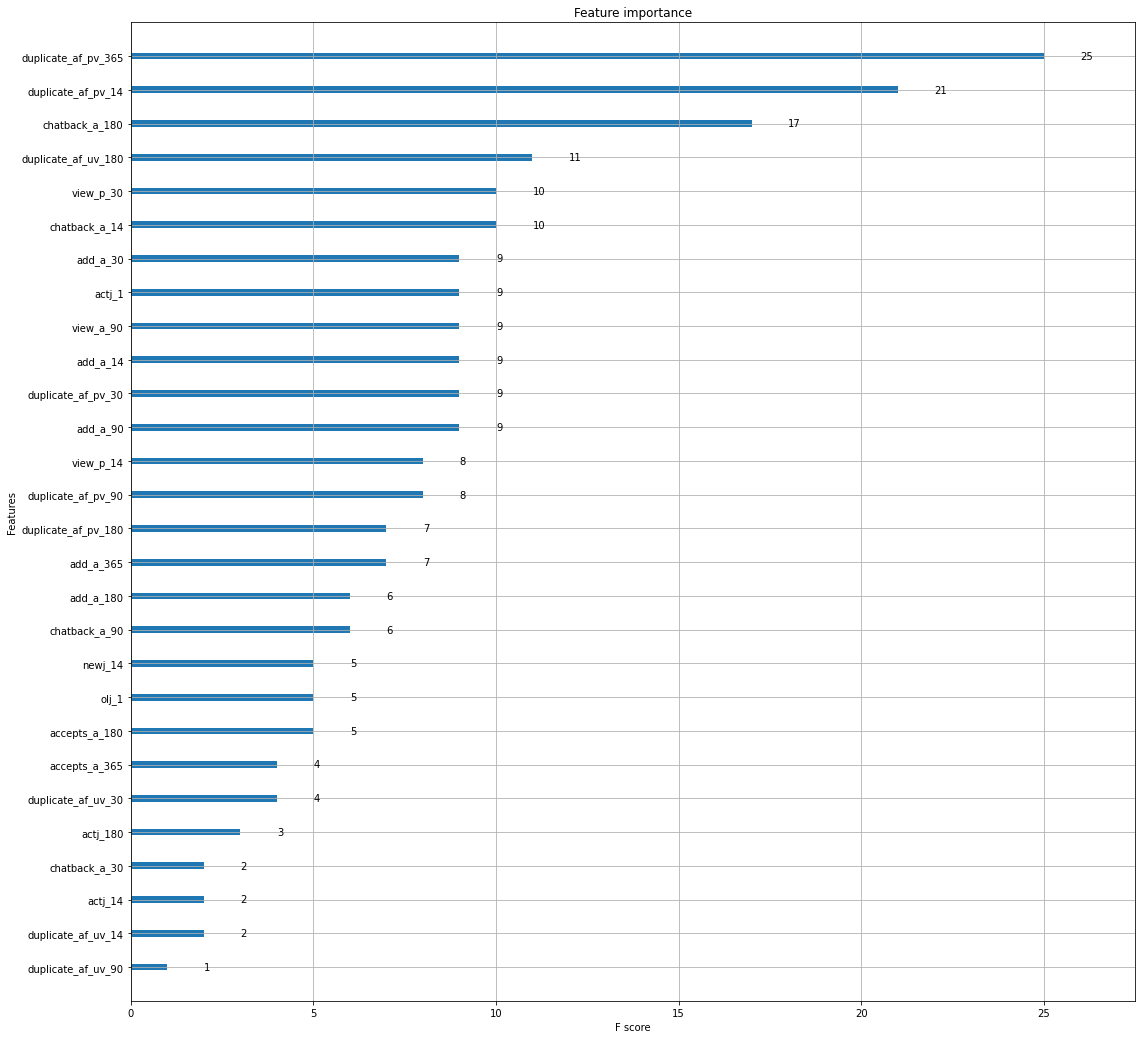

---The metric scores of the test set is---
Precision = 0.520,Recall = 0.322, F_score = 0.495
--- 97.46118974685669 seconds ---


In [198]:
start_time = time.time()
    
random_params, random_score = hypertuning_rscv(cla(),param_grid,nbr_iter, X_cv, y_cv)

classifier_1 = cla(**random_params)
classifier_1.fit(X_cv,y_cv)


print("The selected set of hyperparameters[xgb] is {}.".format(random_params))
##-------------------F score extraction-------------------

#pred_val = np.array(classifier_1.predict(X_val))
prob_val = np.array(classifier_1.predict_proba(X_val)[:,1])

interval = 0.2/10000
threshold = [0.4 + i*interval for i in range(10001)]

frame = pd.DataFrame()
scores_cla = [1]*X_val.shape[0]

for i in threshold:    
    scores_cla = [1 if j > i else 0 for j in prob_val]

    scores_val = list(scores_cla)
    label_val = list(target_val)

    cl = stats_met(label_val,scores_val)

    precision = cl.precision()

    recall = cl.recall()

    f_beta = cl.f_beta(beta = 0.3)

    frame_row = {"threshold":i,"Precision":precision,"Recall":recall,"F_beta":f_beta}
    frame = frame.append(frame_row,ignore_index=True)


threshold_max = frame.loc[frame.F_beta == max(frame.F_beta),"threshold"].iloc[0]

scores_val = [1 if j > threshold_max else 0 for j in prob_val]

labels_val = list(target_val)

val_metrics = stats_met(labels_val,scores_val)

print("---The metric scores of the validation set is---")
val_metrics.get_eval_metrics()

plot_fea = True
if plot_fea:
    plt.rcParams['figure.figsize'] = [18,18]
    plot_importance(classifier_1)
    plt.show()  

## -------------------Training the whole dataset-------------------
classifier_2 = cla(**random_params)
classifier_2.fit(X_train,y_train)


pred_test = classifier_2.predict_proba(X_test)[:,1]

classifier_2.fit(X_train,y_train)

sma_barr_scores_1 = list(pred_test) 
sma_barr_scores_2 = [1 if k > threshold_max else 0 for k in sma_barr_scores_1]

labels_test = list(target_test) ## delete expectancy
scores_test = sma_barr_scores_2

test_metrics = stats_met(labels_test,scores_test)

print("---The metric scores of the test set is---")
test_metrics.get_eval_metrics()

print("--- %s seconds ---" % (time.time() - start_time))

In [385]:
## sub_training and validation set preparation
key_2_train = tot_dat_small_bucket["key_2"]
key_3_train = tot_dat_small_bucket["key_3"]
target_train = tot_dat_small_bucket["is_paid"]
y_train = tot_dat_small_bucket["is_del"]
X_train = tot_dat_small_bucket.drop(["is_paid","key_2","key_3"],axis = 1)


X_cv, X_val, target_cv, target_val = train_test_split(X_train,target_train, test_size=0.3, random_state=18) 

y_cv = X_cv["is_del"]
y_val = X_val["is_del"]

X_train.drop("is_del",axis = 1,inplace = True)
X_cv.drop("is_del",axis = 1,inplace = True)
X_val.drop("is_del",axis = 1,inplace = True)

## test data preparation
key_2_test = tot_dat_test_poked["key_2"]
key_3_test = tot_dat_test_poked["key_3"]
target_test = tot_dat_test_poked["is_paid"]
y_test = tot_dat_test_poked["is_del"]

X_test = tot_dat_test_poked.drop(["is_paid","is_del","key_2","key_3"],axis =1)

In [392]:
X_train.shape

(5407, 30)

In [620]:
cla = XGBClassifier
param_grid ={
        "objective":['reg:logistic'],
        "booster":["gbtree"],
        'n_estimators': [50,100,150,500],
        'min_child_weight': list(range(3,9)), #****
        'max_depth': list(range(2,12)),       #****
        'gamma': [0,1,3,5,7,10,12],              #***
        'subsample': [round(0.1*i,2) for i in range(3,11)],    #**
        'colsample_bytree': [round(0.1*i,2) for i in range(3,11)],  #**
        'eta': [0.01,0.05,0.1,0.2], #*
        'reg_alpha':[0,0.01,0.05,0.1], #*
        'random_state':[18],
        'seed':[6]
}

nbr_iter = 18

## training set
X_train = X_train
y_train = y_train
target_train = target_train

## sub training set
X_cv = X_cv
y_cv = y_cv
target_cv = target_cv

## validation set
X_val = X_val
y_val = y_val
target_val = target_val

## test set
X_test = X_test
y_test = y_test
target_test = target_test

The selected set of hyperparameters[xgb] is {'subsample': 0.7, 'seed': 6, 'reg_alpha': 0.1, 'random_state': 18, 'objective': 'reg:logistic', 'n_estimators': 500, 'min_child_weight': 4, 'max_depth': 8, 'gamma': 12, 'eta': 0.05, 'colsample_bytree': 0.5, 'booster': 'gbtree'}.
---The metric scores of the validation set is---
Precision = 0.506,Recall = 0.341, F_score = 0.487


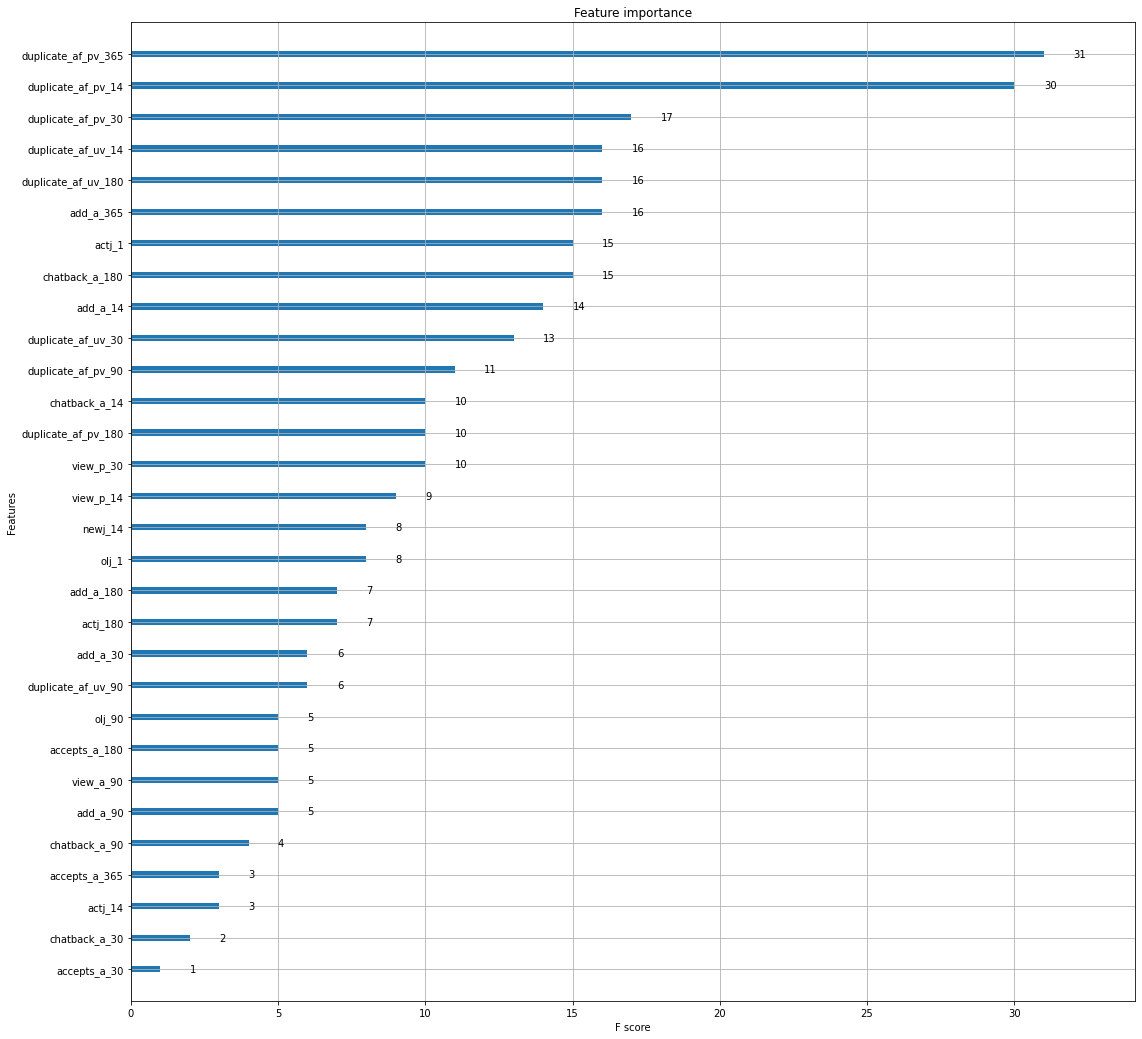

---The metric scores of the test set is---
Precision = 0.516,Recall = 0.326, F_score = 0.492
--- 98.71848917007446 seconds ---


[0.5954200000000001,
 {'subsample': 0.7,
  'seed': 6,
  'reg_alpha': 0.1,
  'random_state': 18,
  'objective': 'reg:logistic',
  'n_estimators': 500,
  'min_child_weight': 4,
  'max_depth': 8,
  'gamma': 12,
  'eta': 0.05,
  'colsample_bytree': 0.5,
  'booster': 'gbtree'}]

In [622]:
model_train(cla,param_grid,nbr_iter,X_train,y_train,target_train,X_cv,y_cv,target_cv,X_val,y_val,target_val,X_test,y_test,target_test,plot_fea = True)

## blocked range calculation

In [585]:
params = {'subsample': 0.6, 'seed': 8, 'reg_alpha': 0, 'random_state': 68, 'objective': 'reg:logistic', 'n_estimators': 100, 'min_child_weight': 4, 'max_depth': 3, 'gamma': 7, 'eta': 0.1, 'colsample_bytree': 0.9, 'booster': 'gbtree'}

threshold_max = 0.5952000000000001

classifier = XGBClassifier(**params)

classifier.fit(X_train,y_train)

pred_test = classifier.predict_proba(X_test)[:,1]

sma_barr_scores_1 = list(pred_test) 
sma_barr_scores_2 = [1 if k > threshold_max else 0 for k in sma_barr_scores_1]

labels_test = list(target_test) ## delete expectancy
scores_test = sma_barr_scores_2

test_metrics = stats_met(labels_test,scores_test)

print("---The metric scores of the test set is---")
test_metrics.get_eval_metrics()

---The metric scores of the test set is---
Precision = 0.520,Recall = 0.322, F_score = 0.495


In [609]:
X_train

,accepts_a_180,accepts_a_30,accepts_a_365,actj_1,actj_14,actj_180,add_a_14,add_a_180,add_a_30,add_a_365,...,duplicate_af_uv_14,duplicate_af_uv_180,duplicate_af_uv_30,duplicate_af_uv_90,newj_14,olj_1,olj_90,view_a_90,view_p_14,view_p_30
0,1.0,0.0,1.0,0,0,1,0.0,1.0,0.0,1.0,...,0.0,46.0,0.0,0.0,0,0,0,0.0,0.0,0.0
1,0.0,0.0,0.0,0,0,1,0.0,0.0,0.0,0.0,...,0.0,15.0,0.0,4.0,0,0,1,7.0,2.0,14.0
2,0.0,0.0,0.0,0,0,1,0.0,0.0,0.0,0.0,...,0.0,72.0,0.0,0.0,0,0,0,0.0,0.0,0.0
3,0.0,0.0,2.0,0,0,0,0.0,0.0,0.0,3.0,...,0.0,1.0,0.0,0.0,0,0,0,0.0,1.0,2.0
4,0.0,0.0,0.0,0,0,0,0.0,1.0,0.0,1.0,...,0.0,3.0,0.0,1.0,0,0,0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5402,0.0,0.0,1.0,0,0,0,0.0,0.0,0.0,16.0,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
5403,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,2.0
5404,7.0,0.0,9.0,0,0,1,0.0,230.0,0.0,299.0,...,0.0,232.0,0.0,77.0,0,0,1,103.0,0.0,0.0
5405,0.0,0.0,0.0,0,0,1,0.0,0.0,0.0,0.0,...,0.0,10.0,1.0,3.0,0,0,1,3.0,3.0,7.0


In [610]:
X_test

,accepts_a_180,accepts_a_30,accepts_a_365,actj_1,actj_14,actj_180,add_a_14,add_a_180,add_a_30,add_a_365,...,duplicate_af_uv_14,duplicate_af_uv_180,duplicate_af_uv_30,duplicate_af_uv_90,newj_14,olj_1,olj_90,view_a_90,view_p_14,view_p_30
0,0.0,0.0,0.0,0,0,1,0.0,0.0,0.0,0.0,...,0.0,15.0,0.0,0.0,0,0,1,0.0,2.0,2.0
1,55.0,0.0,110.0,0,0,3,0.0,2336.0,0.0,3796.0,...,0.0,2380.0,0.0,0.0,0,0,0,0.0,3.0,8.0
2,1.0,0.0,1.0,0,1,1,0.0,57.0,0.0,57.0,...,7.0,134.0,7.0,25.0,0,1,1,36.0,32.0,56.0
3,0.0,0.0,0.0,0,0,0,0.0,1.0,0.0,1.0,...,0.0,2.0,0.0,1.0,0,0,0,1.0,0.0,0.0
4,0.0,0.0,1.0,0,0,1,0.0,1.0,0.0,2.0,...,0.0,45.0,1.0,14.0,0,1,1,3.0,21.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5330,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
5331,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
5332,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
5333,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0


In [643]:
tot_dat_test

,olj_30,newj_14,olj_14,duplicate_af_uv_180,newj_30,actj_30,accepts_a_14,add_a_180,accepts_a_30,actj_1,...,duplicate_af_uv_14,add_a_30,duplicate_af_pv_30,add_a_14,duplicate_af_pv_14,is_paid,is_del,is_poked,key_2,key_3
0,0,0,0,194.0,0,0,0.0,1.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,unpoked,101010100_180300,101010100_180300_99
1,0,0,0,0.0,0,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,unpoked,101010100_180300,101010100_180300_1407
2,0,0,0,0.0,0,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,unpoked,101010100_180300,101010100_180300_1767
3,0,0,0,0.0,0,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,unpoked,101010100_180300,101010100_180300_1803
4,0,0,0,0.0,0,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,unpoked,101010100_180300,101010100_180300_2745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318558,0,0,0,0.0,0,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,unpoked,101310200_160100,101310200_160100_33990617
318559,0,0,0,0.0,0,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,unpoked,101310200_160100,101310200_160100_34028747
318560,0,0,0,0.0,0,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,unpoked,101310200_160100,101310200_160100_34070021
318561,0,0,0,0.0,0,0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0.0,0.0,0,0,unpoked,101310200_160100,101310200_160100_34110407


In [590]:
## the whole test set
tot_dat_test.loc[tot_dat_test["is_paid"] == "paid","is_paid"] = 1
tot_dat_test.loc[tot_dat_test["is_paid"] == "unpaid","is_paid"] = 0

tot_dat_test.loc[tot_dat_test["is_del"] == "deleted","is_del"] = 1
tot_dat_test.loc[tot_dat_test["is_del"] == "undeleted","is_del"] = 0

X_range = tot_dat_test.drop(["is_poked","key_2","key_3","is_del","is_paid"],axis = 1)
key2_test_all = tot_dat_test["key_2"]
key3_test_all = tot_dat_test["key_3"]
y_test_all = tot_dat_test["is_del"]
target_test_all = tot_dat_test["is_paid"]

In [591]:
params = {'subsample': 0.6, 'seed': 8, 'reg_alpha': 0, 'random_state': 68, 'objective': 'reg:logistic', 'n_estimators': 100, 'min_child_weight': 4, 'max_depth': 3, 'gamma': 7, 'eta': 0.1, 'colsample_bytree': 0.9, 'booster': 'gbtree'}

threshold_max = 0.5952000000000001

classifier = XGBClassifier(**params)

classifier.fit(X_train,y_train)

pred_test_all = classifier.predict_proba(X_range)[:,1]

In [593]:
sma_barr_scores_test = [1 if k > threshold_max else 0 for k in list(pred_test_all)]

In [600]:
aug_small_bucket["is_head"] = np.array(sma_barr_scores_test)

In [603]:
aug_small_bucket.loc[aug_small_bucket.is_head == 1,:].shape

(11122, 95)

In [604]:
sum(aug_small_bucket.loc[aug_small_bucket.is_head == 1,"olj_1"])/sum(aug_small_bucket["olj_1"])

0.37765393688673116

In [446]:
sum(aug_small_bucket["olj_1"])

58498

In [616]:
is_head = aug_small_bucket.loc[aug_small_bucket.is_head ==1,["key_3","is_head"]].reset_index(drop = True)

In [645]:
sum(aug_small_bucket.loc[aug_small_bucket.is_head==1,"sales"])/sum(aug_small_bucket["sales"])

0.28888226305393017

In [630]:
city_l2 = aug_small_bucket.loc[aug_small_bucket.is_head ==1,["key_2","is_head"]].drop_duplicates().reset_index(drop = True)

In [631]:
city_l2

,key_2,is_head
0,101010100_180300,1
1,101020100_180300,1
2,101030100_170100,1
3,101040100_170200,1
4,101050100_160700,1
...,...,...
96,101310200_160100,1
97,101190800_160200,1
98,101280300_160200,1
99,101230500_160200,1


In [641]:
city_l2.to_csv(r"/Users/admin/Desktop/xilai folder/头部建模/city_l2.csv", index = False)

In [619]:
is_head.to_csv(r"/Users/admin/Desktop/xilai folder/头部建模/is_head.csv", index = False)

In [642]:
is_head.shape

(11122, 2)

In [640]:
city_l2 = aug_small_bucket[["key_2"]].drop_duplicates().reset_index(drop =True)

## Random Forest

In [161]:
cla = RandomForestClassifier

param_rf = {
    'criterion':['gini','entropy'],
    'min_samples_split':[2,3,5,6,8,10,12],
    'bootstrap': [True],
    'max_depth': [i for i in range(1,6)],
    'max_features': [i for i in range(6,12)],
    'min_samples_leaf': [3,4,5,6,7],
    'min_samples_split': [2,3,5,6],
    'n_estimators': [180],
    'random_state': [68]
}

nbr_iter = 18

## training set
X_train = X_train
y_train = y_train
target_train = target_train

## sub training set
X_cv = X_cv
y_cv = y_cv
target_cv = target_cv

## validation set
X_val = X_val
y_val = y_val
target_val = target_val

## test set
X_test = X_test
y_test = y_test
target_test = target_test

In [171]:
model_train(cla,param_rf,nbr_iter,X_train,y_train,target_train,X_cv,y_cv,target_cv,X_val,y_val,target_val,X_test,y_test,target_test,plot = False,plot_fea = False)

[18:22:01] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { bootstrap, criterion, max_features, min_samples_leaf, min_samples_split } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:22:01] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:22:01] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/lea

## Logistic Regression

In [172]:
cla = LogisticRegression

param_lg = {'penalty':["l2"],
              'C': [1,5,10,15,20]}

nbr_iter = 18

## training set
X_train = X_train
y_train = y_train
target_train = target_train

## sub training set
X_cv = X_cv
y_cv = y_cv
target_cv = target_cv

## validation set
X_val = X_val
y_val = y_val
target_val = target_val

## test set
X_test = X_test
y_test = y_test
target_test = target_test

In [173]:
model_train(cla,param_lg,nbr_iter,X_train,y_train,target_train,X_cv,y_cv,target_cv,X_val,y_val,target_val,X_test,y_test,target_test,plot = False,plot_fea = False)

The selected set of hyperparameters[xgb] is {'penalty': 'l2', 'C': 1}.
---The metric scores of the validation set is---
Precision = 0.507,Recall = 0.357, F_score = 0.490
---The metric scores of the test set is---
Precision = 0.500,Recall = 0.310, F_score = 0.476
--- 14.338035345077515 seconds ---


In [651]:
july_poked['view_a_14'].value_counts()

0.0       48300
1.0        1818
2.0        1128
3.0         781
4.0         676
          ...  
4642.0        1
2071.0        1
2050.0        1
3078.0        1
2878.0        1
Name: view_a_14, Length: 1859, dtype: int64

In [652]:
july_poked["sales"].value_counts()

0.0       39045
60.0      16494
30.0       7295
120.0      2208
148.0      1991
          ...  
1080.0        1
346.0         1
188.0         1
182.0         1
652.0         1
Name: sales, Length: 247, dtype: int64

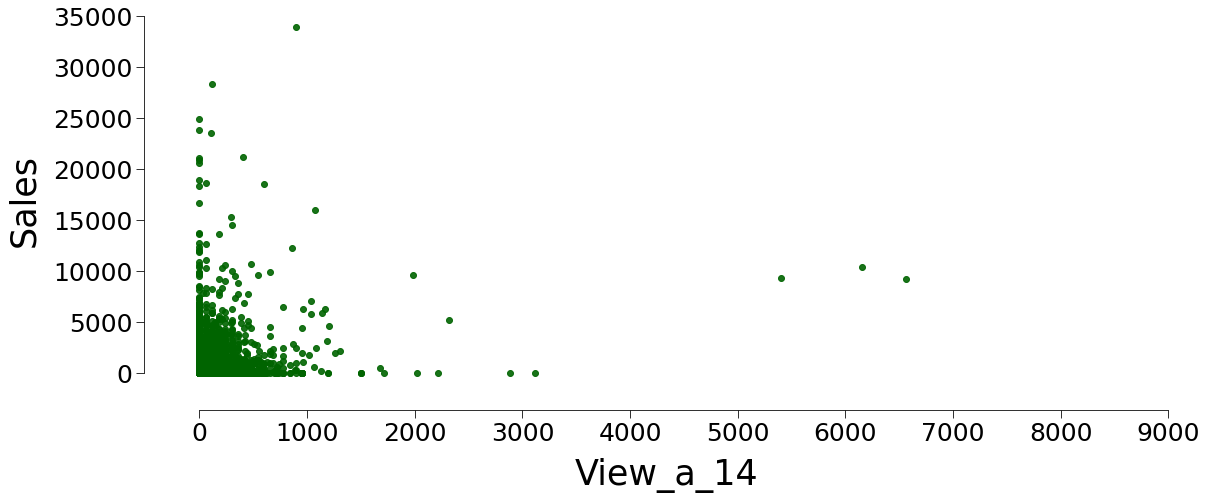

In [663]:
fig, ax = plt.subplots(1,1,figsize=(18,7))

view = july_poked['view_a_14']
sales = july_poked["sales"]

ax.scatter(sales,view,alpha = 0.9,color = 'darkgreen')

ax.set_xticks([1000*i for i in range(10)])
#ax.set_xticklabels([1000*i for i in range(5)])

ax.set_yticks([5000*i for i in range(8)])
#ax.set_yticklabels([5000*i for i in range(8)])

ax.spines['bottom'].set_bounds(0,9000)
ax.spines['left'].set_bounds(0,35000)


ax.tick_params(axis= "both",direction = 'out',which='major', length=8,width=0.8, color='k',labelsize = 25)



ax.set_ylabel("Sales",size = 35,labelpad=12)
ax.set_xlabel("View_a_14",size = 35,labelpad=12)
adjust_spines(ax, ['left', 'bottom'])


In [17]:
july_small_poked

,is_poked,is_paid,sales,is_del,del_exp_cnt,olj_1,olj_14,olj_30,olj_90,olj_180,...,duplicate_af_uv_365,duplicate_af_uv_past_same,duplicate_af_pv_14,duplicate_af_pv_30,duplicate_af_pv_90,duplicate_af_pv_180,duplicate_af_pv_365,duplicate_af_pv_past_same,key_2,key_3
0,poked,unpaid,0.0,undeleted,0,0,0,0,0,1,...,46.0,0.0,0.0,0.0,0.0,46.0,46.0,0.0,101010100_180300,101010100_180300_599367
1,poked,unpaid,0.0,undeleted,0,0,0,1,1,1,...,84.0,61.0,0.0,0.0,4.0,16.0,88.0,61.0,101010100_180300,101010100_180300_1970217
2,poked,paid,60.0,undeleted,0,0,0,0,0,1,...,72.0,0.0,0.0,0.0,0.0,72.0,72.0,0.0,101010100_180300,101010100_180300_2026341
3,poked,unpaid,0.0,undeleted,0,0,0,0,0,0,...,59.0,73.0,0.0,0.0,0.0,1.0,61.0,74.0,101010100_180300,101010100_180300_2636043
4,poked,unpaid,0.0,undeleted,0,0,0,0,0,1,...,44.0,4.0,0.0,0.0,1.0,3.0,44.0,4.0,101010100_180300,101010100_180300_4517955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5402,poked,unpaid,0.0,undeleted,0,0,0,0,0,0,...,17.0,1.0,0.0,0.0,0.0,0.0,17.0,1.0,101310200_160100,101310200_160100_13610136
5403,poked,unpaid,0.0,undeleted,0,0,0,0,0,0,...,3.0,3.0,0.0,0.0,0.0,0.0,4.0,3.0,101310200_160100,101310200_160100_18831636
5404,poked,unpaid,0.0,undeleted,0,0,0,1,1,1,...,302.0,0.0,0.0,0.0,77.0,232.0,302.0,0.0,101310200_160100,101310200_160100_29662668
5405,poked,unpaid,0.0,deleted,2,0,0,1,1,1,...,11.0,0.0,0.0,1.0,3.0,10.0,11.0,0.0,101310200_160100,101310200_160100_30918798


In [19]:
july_small_poked.loc[july_small_poked["is_paid"] == "paid","is_paid"] = 1
july_small_poked.loc[july_small_poked["is_paid"] == "unpaid","is_paid"] = 0

july_small_poked.loc[july_small_poked["is_del"] == "deleted","is_del"] = 1
july_small_poked.loc[july_small_poked["is_del"] == "undeleted","is_del"] = 0

In [21]:
july_small_poked

target_train = july_small_poked["is_paid"]

In [24]:
july_small_poked.columns

Index(['is_poked', 'is_paid', 'sales', 'is_del', 'del_exp_cnt', 'olj_1',
       'olj_14', 'olj_30', 'olj_90', 'olj_180', 'olj_365', 'olj_past_same',
       'actj_1', 'actj_14', 'actj_30', 'actj_90', 'actj_180', 'actj_365',
       'actj_past_same', 'newj_1', 'newj_14', 'newj_30', 'newj_90', 'newj_180',
       'newj_365', 'newj_past_same', 'exposure_pv_14', 'exposure_pv_30',
       'exposure_pv_90', 'exposure_pv_180', 'exposure_pv_365',
       'exposure_pv_past_same', 'view_a_14', 'view_a_30', 'view_a_90',
       'view_a_180', 'view_a_365', 'view_a_past_same', 'add_a_14', 'add_a_30',
       'add_a_90', 'add_a_180', 'add_a_365', 'add_a_past_same',
       'chatback_a_14', 'chatback_a_30', 'chatback_a_90', 'chatback_a_180',
       'chatback_a_365', 'chatback_a_past_same', 'accepts_a_14',
       'accepts_a_30', 'accepts_a_90', 'accepts_a_180', 'accepts_a_365',
       'accepts_a_past_same', 'view_p_14', 'view_p_30', 'view_p_90',
       'view_p_180', 'view_p_365', 'view_p_past_same', 'add_p_14